In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 35.3 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [ ]:
def vec_check(vec,electron_num):
    """
    To check solution conserve the charge
    """
    for i,e in enumerate(vec):
        if np.abs(e) > 1e-8:
            e_occ=bin(i)[2:]
            lst=' '.join(e_occ).split(' ')
            cv=tuple(map(int, lst))
            e_num=sum(cv)
            if e_num!=electron_num:
                return False
    return True

def exact_ch_energy(num_electrons,symbol,geometry,charge):
    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    vals, vecs = np.linalg.eigh(H_matrix)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]
    E_collect=[0,0,0,0]
    E_collect[0]=eng[0]
    print('The ground state energy with sz=0:',eng[0])

    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    Stop=[False,False,False]

    elec_num=num_electrons
    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if np.abs(Sz) < 1e-5 and vec_check(vec[:,i],elec_num):
            print('The first excied state energy with sz=0:',eng[i])
            Stop[0]=True
            E_collect[1]=eng[i]
        elif np.abs(Sz-1) < 1e-5 and vec_check(vec[:,i],elec_num):
            print('The first excied state energy with sz=1:',eng[i])
            Stop[1]=True
            E_collect[2]=eng[i]
        elif np.abs(Sz+1) < 1e-5 and vec_check(vec[:,i],elec_num):
            print('The first excied state energy with sz=-1:',eng[i])
            Stop[2]=True
            E_collect[3]=eng[i]
        if np.all(Stop):
            break
    return E_collect

In [ ]:
r=1.6
a0=0.529177210903
L=r/a0
symbol=["H", "Li"]
geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

charge=0
num_electrons=2
exact_ch_energy(num_electrons,symbol,geometry,charge)

The ground state energy with sz=0: -7.8820966145866365
The first excied state energy with sz=1: -7.766004935721787
The first excied state energy with sz=0: -7.766004935721786
The first excied state energy with sz=-1: -7.766004935721785


[-7.8820966145866365,
 -7.766004935721786,
 -7.766004935721787,
 -7.766004935721785]

In [ ]:
def depth(qnode):
    def _fn(*args, **kwargs):
        qnode.construct(args, kwargs)
        return qnode.qtape.get_depth()
    return _fn

In [ ]:
def bit_to_vec(bitstring_dict,num_qubits):
    vec=np.zeros(2**num_qubits)
    amp=0
    for i in range(2**num_qubits):
        bitstr=bin(i)[2:]
        if len(bitstr) < num_qubits:
            bitstr=(num_qubits-len(bitstr))*'0'+bitstr

        if bitstr in bitstring_dict:
            vec[i]=bitstring_dict[bitstr]
            amp+=np.abs(bitstring_dict[bitstr])**2
    vec=vec/np.sqrt(amp)
    return vec

In [ ]:
class FS_vqe():
    def __init__(self,state,num_electrons,symbol,geometry,charge,omega=0.0) -> None:
        self.num_electrons=num_electrons
        self.symbol=symbol
        self.geometry=geometry
        self.charge=charge

        self.hamiltonian=self.Ch_hamiltonian(symbol,geometry,num_electrons,charge)
        self.num_qubits = len(self.hamiltonian.wires)
        self.sz=qml.qchem.spinz(self.num_qubits)
        self.singles, self.doubles = qml.qchem.excitations(self.num_electrons, self.num_qubits)

        self.state=bit_to_vec(state,self.num_qubits)
        H_matrix=qml.matrix(self.hamiltonian)
        #H_matrix=H_matrix
        self.omega=omega
        H_sq=H_matrix.dot(H_matrix)
        H_sq=H_sq-2*omega*H_matrix

        self.H_sq_ob=qml.Hermitian(H_sq, wires=range(self.num_qubits))
        self.dev = qml.device("default.qubit", wires=self.num_qubits)
        self.cost_h_fn = qml.QNode(self.circuit, self.dev)
        self.Sz_fn = qml.QNode(self.circuit_sz, self.dev)
        self.cost_hsq_fn = qml.QNode(self.circuit_h_sq, self.dev)#, interfce="autograd")

    def Ch_hamiltonian(self,symbol,geometry,num_electrons,charge):
        return qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]

    def hf(self,electrons, num_qubits):
        return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

    def circuit(self,weights):
        qml.StatePrep(self.state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+d_l+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.hamiltonian)

    def circuit_h_sq(self,weights):
        qml.StatePrep(self.state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+d_l+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.H_sq_ob)

    def circuit_sz(self,weights):
        qml.StatePrep(self.state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+d_l+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.sz)

    def cost_fn(self,params):
        return np.sqrt(self.cost_hsq_fn(params)+(self.omega**2))

    def run(self,alpa=0.0,epochs=400,stepsize=0.5,num_layer=2,cov=1e-6,print_train=True):
        self.alpa=alpa
        #self.omega=omega
        self.num_layer=num_layer
        #opt = qml.AdamOptimizer(stepsize=stepsize)
        #opt = qml.QNGOptimizer(stepsize, lam=0.001, approx="block-diag")
        #adj_metric_tensor = qml.adjoint_metric_tensor(self.cost_hsq_fn)
        #opt = qml.QNGOptimizer(stepsize, lam=0.001,approx="block-diag")
        opt = qml.GradientDescentOptimizer(stepsize)
        num_params=self.num_layer*len(self.doubles + self.singles)
        self.weights =np.zeros(self.num_layer*len(self.doubles + self.singles), requires_grad=True)#np.random.uniform(low=0, high=2 * np.pi, size=num_params, requires_grad=True)#
        i=0
        self.iter=[]
        self.cost_val=[]
        Lowest_cost=0
        #self.best_weights=self.weights

        cov=cov
        E0_pev=0
        for _ in range(epochs):
            self.weights = opt.step(self.cost_hsq_fn, self.weights)#, metric_tensor_fn=adj_metric_tensor)
            self.iter.append(i)
            cost=self.cost_fn(self.weights)
            E0=self.cost_h_fn(self.weights)

            #if Lowest_cost>cost:
            #    Lowest_cost=cost
            #    self.best_weights=self.weights
            self.cost_val.append(cost)

            i=i+1
            if print_train:
                print('iter:',i,' E0:',E0,' Sz:',self.Sz_fn(self.weights))
                print(cost)
            if np.abs(E0-E0_pev)<cov:
                break

            E0_pev=E0
        self.E0=E0
        return E0

In [ ]:
r=1.6
a0=0.529177210903
L=r/a0
symbol=["H", "Li"]
geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

charge=0
num_electrons=2
e_trial_stat_sz0={'0110000000': 1, '1001000000':1}
FS_vqe=FS_vqe(e_trial_stat_sz0,num_electrons,symbol,geometry,charge,omega=-7.8)

In [ ]:
FS_vqe.run(stepsize=0.07,num_layer=3)

iter: 1  E0: -7.723617136862178  Sz: 0.0
0.17220713087698433
iter: 2  E0: -7.725182124943396  Sz: -2.7755575615628914e-17
0.16894879450605196
iter: 3  E0: -7.726684712821117  Sz: 0.0
0.1657586966856869
iter: 4  E0: -7.728127077523762  Sz: -2.7755575615628914e-17
0.16263620749044466
iter: 5  E0: -7.7295113441636  Sz: 0.0
0.1595806712115195
iter: 6  E0: -7.730839585172393  Sz: 2.7755575615628914e-17
0.1565914084057487
iter: 7  E0: -7.7321138197548205  Sz: 0.0
0.15366771784421351
iter: 8  E0: -7.7333360135414955  Sz: 0.0
0.15080887836748072
iter: 9  E0: -7.734508078424773  Sz: 0.0
0.14801415064220816
iter: 10  E0: -7.735631872560879  Sz: 0.0
0.1452827788283894
iter: 11  E0: -7.736709200523203  Sz: 0.0
0.1426139921519278
iter: 12  E0: -7.737741813592033  Sz: 0.0
0.14000700639145014
iter: 13  E0: -7.7387314101673175  Sz: 0.0
0.1374610252762621
iter: 14  E0: -7.739679636291576  Sz: -2.7755575615628914e-17
0.13497524180142761
iter: 15  E0: -7.740588086270849  Sz: 5.551115123125783e-17
0.13254

tensor(-7.76035149, requires_grad=True)

In [ ]:
GD_cost_val=FS_vqe_X_test.cost_val
GD_cost_val=FS_vqe_X_test.cost_val
#ADAM_cost_val=FS_vqe_X_test.cost_val
#ADAM_iter=FS_vqe_X_test.iter
#QNG_cost_val=FS_vqe_X_test.cost_val
#QNG_iter=FS_vqe_X_test.iter

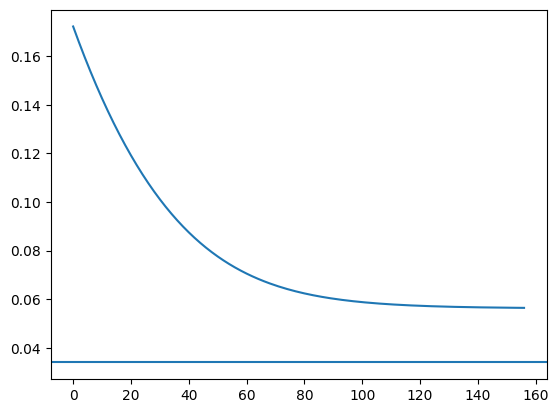

In [ ]:
plt.plot(FS_vqe_X_test.iter,FS_vqe_X_test.cost_val)
plt.axhline(0.03399506427821475)

In [ ]:
with open('GD_cost.npy', 'wb') as f:
    np.save(f, np.array(GD_cost_val))

#with open('ADAM_cost.npy', 'wb') as f:
#    np.save(f, np.array(ADAM_cost_val))

#with open('QNG_cost.npy', 'wb') as f:
#    np.save(f, np.array(QNG_cost_val))

In [ ]:
with open('GD_iter.npy', 'wb') as f:
    np.save(f, np.array(GD_iter))

#with open('ADAM_iter.npy', 'wb') as f:
#    np.save(f, np.array(ADAM_iter))

#with open('QNG_cost.npy', 'wb') as f:
#    np.save(f, np.array(QNG_val))